In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sea

In [3]:
df = pd.read_csv("hour.csv")

In [4]:
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [5]:
df.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

In [6]:
df.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [7]:
df.isnull().values.any()

np.False_

In [8]:
usedDat = df[["season", "temp","mnth","windspeed", "registered", "cnt"]]

There are no missing or NA values so therefore we don't have to deal with removing or imputing any values

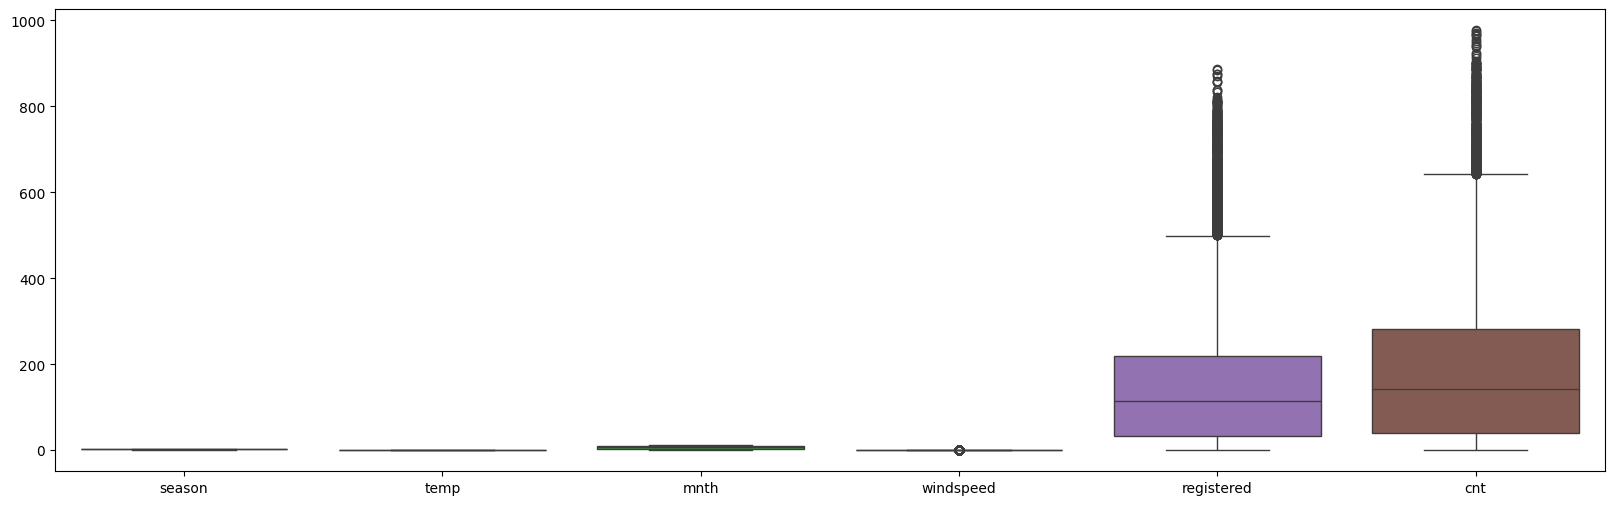

In [9]:

plt.figure(figsize=(20,6))
sea.boxplot(data=usedDat.select_dtypes(include='number'))
plt.show()

In [10]:
col = "registered"

Q1 = usedDat[col].quantile(0.25)
Q3 = usedDat[col].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outs = usedDat[(usedDat[col] < lower_bound) | (usedDat[col] > upper_bound)]

In [11]:
print("Q1:", Q1)
print("Q3:", Q3)
print("IQR:", IQR)
print("Lower bound:", lower_bound)
print("Upper bound:", upper_bound)

print("\nNumber of outliers:", outs.shape[0])
print(outs["registered"].describe())

Q1: 34.0
Q3: 220.0
IQR: 186.0
Lower bound: -245.0
Upper bound: 499.0

Number of outliers: 680
count    680.000000
mean     630.407353
std       92.822159
min      500.000000
25%      544.750000
50%      621.500000
75%      701.250000
max      886.000000
Name: registered, dtype: float64


In [12]:
col = "cnt"

Q1 = usedDat[col].quantile(0.25)
Q3 = usedDat[col].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outs = usedDat[(usedDat[col] < lower_bound) | (usedDat[col] > upper_bound)]

In [13]:
print("Q1:", Q1)
print("Q3:", Q3)
print("IQR:", IQR)
print("Lower bound:", lower_bound)
print("Upper bound:", upper_bound)

print("\nNumber of outliers:", outs.shape[0])
print(outs["cnt"].describe())

Q1: 40.0
Q3: 281.0
IQR: 241.0
Lower bound: -321.5
Upper bound: 642.5

Number of outliers: 505
count    505.000000
mean     749.243564
std       80.900280
min      643.000000
25%      681.000000
50%      730.000000
75%      812.000000
max      977.000000
Name: cnt, dtype: float64


We believe it would benefit our model to include outliers as the outliers could provide helpful insight into days and times in which the choice of public transit is at maximum and/or minimum values. In theory this should provide dramatic insights into the importance of weather and seasons on bike rentals if there are extreme highs and lows during specific times of the day or year.

Now we're going to pick the variables we want to observe, drop the ones we don't care about, and scale them.

In [ ]:
drop_cols = ["instant","dteday","casual","registered","hr","temp","season"]
df_dropped = df.drop(columns=[c for c in drop_cols if c in df.columns])
df_dropped.columns

Index(['yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'atemp',
       'hum', 'windspeed', 'cnt'],
      dtype='object')

FEATURE SELECTION:

We chose these predictors because they capture the two major components of bike-rental demand: time-based patterns (season, year, month, weekday, holiday, working day) and weather conditions (temperature, humidity, wind, and weather situation). Together, these variables directly influence when people choose to ride and how weather affects bike availability and comfort, making them the strongest and most relevant features for predicting daily bike rentals.

In [48]:
predictors = ["yr", "mnth", "weekday", "holiday", "workingday","weathersit", "atemp", "hum", "windspeed" ]
target = "cnt"

X = df_dropped[predictors]
y = df_dropped[target]

Splitting the data for test data and training data...

Reasoning: If our model uses all 100% of the data provided it could generate a regression that is only fit to this specific dataset, by witholding some of the information we can draw meaningful conclusions from it.

In [82]:
import sklearn.model_selection as ms

X_train, X_test, y_train, y_test = ms.train_test_split(
    X, y, test_size=0.2, random_state=42
)

Figuring out which are numeric...

In [83]:
df_dropped.dtypes

yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
atemp         float64
hum           float64
windspeed     float64
cnt             int64
dtype: object

Taking the numeric columns and scaling them...

Chose standard scaler because our type of model and data better suit the more standardized scale it provides. (Mean = 0, Standard deviation = 1, e.t.c)

In [ ]:
numeric_cols = ["atemp", "hum", "windspeed"]
categorical_cols = [col for col in predictors if col not in numeric_cols]

scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

Feature Selection

In [52]:
print("Our Selected variables are ",df_dropped.columns.tolist())

Our Selected variables are  ['yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'atemp', 'hum', 'windspeed', 'cnt']


We have chosen these values because they provide apt expl

In [53]:
X.describe()

,yr,mnth,weekday,holiday,workingday,weathersit,atemp,hum,windspeed
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,0.502561,6.537775,3.003683,0.028770,0.682721,1.425283,0.475775,0.627229,0.190098
std,0.500008,3.438776,2.005771,0.167165,0.465431,0.639357,0.171850,0.192930,0.122340
min,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,4.000000,1.000000,0.000000,0.000000,1.000000,0.333300,0.480000,0.104500
50%,1.000000,7.000000,3.000000,0.000000,1.000000,1.000000,0.484800,0.630000,0.194000
75%,1.000000,10.000000,5.000000,0.000000,1.000000,2.000000,0.621200,0.780000,0.253700
max,1.000000,12.000000,6.000000,1.000000,1.000000,4.000000,1.000000,1.000000,0.850700


In [54]:

y.describe()

count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: cnt, dtype: float64

The predictor features include: "yr", "mnth", "weekday", "holiday", "workingday","weathersit", "temp", "atemp", "hum", "windspeed"
while our target feature is "cnt"

<Axes: >

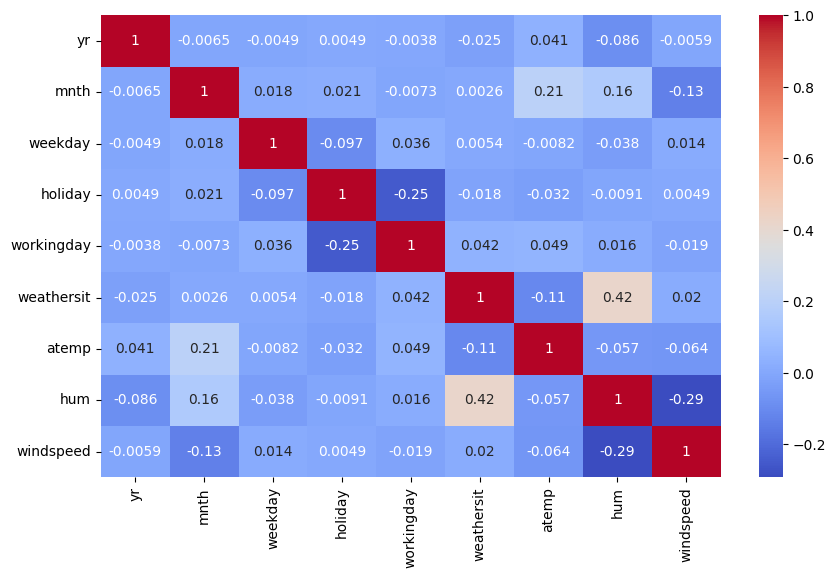

In [55]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(X_train_scaled.corr(), annot=True, cmap='coolwarm')

In [90]:
model = LinearRegression()
model.fit(X_train, y_train)

fit_vals = model.predict(X_train)
resids = y_train - fit_vals

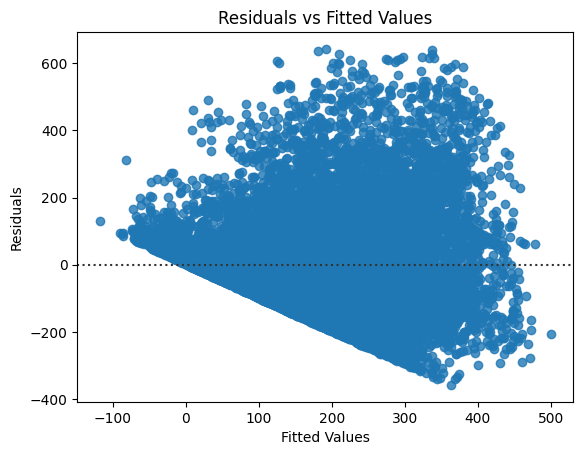

In [97]:
from statsmodels.nonparametric.smoothers_lowess import lowess

sns.residplot(x=fit_vals, y=resids)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.show()

Checking Normality of residuals

(array([   9.,   34.,  119.,  272.,  432.,  742.,  998., 1252., 1551.,
        1614., 1451., 1188.,  899.,  661.,  538.,  447.,  359.,  270.,
         226.,  180.,  162.,  123.,   79.,   78.,   68.,   53.,   53.,
          15.,   16.,   14.]),
 array([-357.68860785, -324.34736469, -291.00612152, -257.66487836,
        -224.32363519, -190.98239203, -157.64114887, -124.2999057 ,
         -90.95866254,  -57.61741937,  -24.27617621,    9.06506695,
          42.40631012,   75.74755328,  109.08879645,  142.43003961,
         175.77128278,  209.11252594,  242.4537691 ,  275.79501227,
         309.13625543,  342.4774986 ,  375.81874176,  409.15998493,
         442.50122809,  475.84247125,  509.18371442,  542.52495758,
         575.86620075,  609.20744391,  642.54868707]),
 <BarContainer object of 30 artists>)

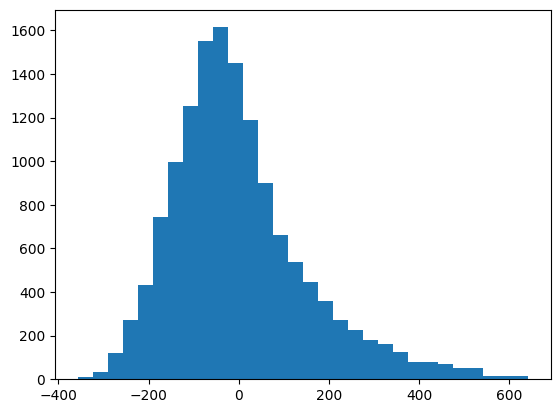

In [98]:
plt.hist(resids, bins=30)

Checking Independence

In [100]:
from statsmodels.stats.stattools import durbin_watson

dw = durbin_watson(resids)
print(dw)

2.0119123522492486


Building Model

In [105]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

In [107]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(rmse)
print(r2)

148.32185364942728
0.30525543987884285


In [108]:
from sklearn.ensemble import RandomForestRegressor

randfor = RandomForestRegressor(random_state=50)
randfor.fit(X_train, y_train)

y_pred_rf = randfor.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("Rf RMSE:", rmse_rf)
print("Rf R²:", r2_rf)

Rf RMSE: 131.64982493243244
Rf R²: 0.45266220543972646
